In [116]:
import pandas as pd
import numpy as np
from math import ceil
import time
import glob,os
import re
import matplotlib.pyplot as plt
import pickle

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 

Using TensorFlow backend.


In [2]:
DesignID=pd.read_csv('OptDesign.csv',sep=',',header=1)            #experiment design codes for adults




DesignID=pd.get_dummies(data=DesignID,columns=['Full Braking Before Impact','Weather','Road Type','Day or Night'])


DesignID=DesignID.drop(columns=['Unnamed: 0'],axis=1)


def scantext():                                                       #text files of VR data
    x=[]
    for path,dirs,files in os.walk('/home/arash/VRdata/Data/'):
        for f in files:
            if f.endswith('.txt'):
                x.append(os.path.join(path,f))
    return(x)



alltext=scantext()
        

In [3]:
googleforms=pd.read_csv('/home/arash/VRdata/Google Forms/PED-AV Questionnaire.csv',sep=',',header=0)

In [4]:
googleforms=pd.get_dummies(data=googleforms,columns=['Age','Gender','Occupation','Education','driving license','mode',
                                                     'workwalk','shopwalk','Vrexp','Heart','vision','anxiety', 'Headaches','dizziness'])

googleforms=googleforms.drop(columns=['Gender_Male','driving license_No','Vrexp_No','numwalk','Education_kid'],axis=1)            #numwalk is not reported in a readible form so i remove it temporarly

googleforms=googleforms.rename(columns={'Age_12-Sep':'Age_9-12',
                            'Age_15-Dec':'Age_12-15'
                           })

In [5]:
googleforms.shape

(113, 45)

In [6]:
experiments=[]
for filename in alltext:
    lastslashindex=filename.rfind('/')
    onetolastslashindex=filename[:lastslashindex].rfind('/')
    name=filename[onetolastslashindex+1:lastslashindex]                         #name of the participant
    hyphen=filename[lastslashindex:].find('-')
    desID=int(filename[lastslashindex+1:][:hyphen-1])                             #scenario ID
    df=pd.read_csv(filename,header=None,names=['status','y','height','x',4,5,'o1','o2','o3','timeelaspsed','timehr','timemin','timesec'],sep=':|;|,|\(|\)',engine='python')   #x,y,height: coordinates,     #o1,o2,o3: head orientation
    df=df.drop(columns=[4,5],axis=1)
    

    df['scenario']=desID
    df['name']=name
    df['filename']=filename[24:]
    tindex=(df.index[df['status']=='u ']-1).tolist()
    pindex=(df.index[df['status']=='u ']).tolist()
    df.iloc[pindex,df.columns.get_loc('timeelaspsed')]=df.iloc[tindex,0].values
    df.iloc[pindex,df.columns.get_loc('timehr')]=df.iloc[tindex,1].values
    df.iloc[pindex,df.columns.get_loc('timemin')]=df.iloc[tindex,2].values
    df.iloc[pindex,df.columns.get_loc('timesec')]=df.iloc[tindex,3].values
    df=df.drop(df.index[tindex])
    df=df.reset_index()
    df=df.drop('index',axis=1)
    
    
    
    experiments.append(df)
    
#Row1: u: user, L: car on the bottom lane   R:Car on top lane, NaN: different points of cars     
#columns: y:axis parallel to street, increases in the left side of user, x: axix Perpendicular to street, dicreases when user crosses the road

In [7]:
ALLDATA=pd.DataFrame(index=range(len(experiments)),columns=['File','Scenario','Wait Time (s)','PET (s)', 
       'Distace to Collision Point','Card ID', 'Speed Limit', 'Lane Width', 'Minimum Gap',
       'Mean Arrival Rate', 'AV', 'Full Braking Before Impact_-1.0',
       'Full Braking Before Impact_1', 'Full Braking Before Impact_2',
       'Full Braking Before Impact_3', 'Clear', 'Snowy',
       'One way', 'two way',
       'Two way with median', 'Day','Night','name', 'numcars', 'Vrexpnum', 'Age_9-12', 'Age_15-18', 'Age_12-15',
       'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Age_40 - 49',
       'Age_50 - 59', 'Age_60+', 'Gender_Female', 'Occupation_Employed',
       'Occupation_Student', 'Occupation_Unemployed', 'Occupation_kid',
       'Education_Bachelors degree', 'Education_College/University student',
       'Education_Doctorate degree', 'Education_High school diploma',
       'Education_Masters degree', 'Education_Professional degree',
       'driving license_Yes', 'mode_Bike', 'mode_Car', 'mode_Public Transit',
       'mode_Walking', 'workwalk_No', 'workwalk_Sometimes', 'workwalk_Yes',
       'shopwalk_No', 'shopwalk_Sometimes', 'shopwalk_Yes', 'shopwalk_kid',
       'Vrexp_Yes', 'Heart_Currently', 'Heart_Over the years',
       'vision_Currently', 'vision_Over the years', 'anxiety_Currently',
       'anxiety_Over the years', 'Headaches_Currently',
       'Headaches_Over the years', 'dizziness_Over the years','starttime'])

In [18]:
for n in range(len(experiments)):
    if not 1<= experiments[n]['scenario'][0] <87:         #check if the scenario is valid
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,1]='Err3'
        ALLDATA.iloc[n,2]='Err3'                     #error 3: scenario is not valid
        ALLDATA.iloc[n,3]='Err3'
        ALLDATA.iloc[n,4]='Err3'
        ALLDATA.iloc[n,5:22]='Err3'
        ALLDATA.iloc[n,22:67]='Err3'
        ALLDATA.iloc[n,67]='Err3'

        continue
    
    pindex=(experiments[n].index[experiments[n]['status']=='u ']).tolist()     #indces of pedestrians in the experiment dataset

    for index, item in enumerate(pindex):                                      #adding time to all u, L, R and NaN rows
        if index>1:
            experiments[n].iloc[pindex[index-1]:pindex[index],7]=experiments[n].iloc[pindex[index-1],7]
    experiments[n].iloc[max(pindex):,7]=experiments[n].iloc[max(pindex),7]        


    #wait time calculation
    if len(experiments[n]['status'][experiments[n]['status']=='L0 '])>0:                    #to check if first car appears at all
        firstcarL=experiments[n]['status'][experiments[n]['status']=='L0 '].index[0]    #index of first car on L lane
    else:
        firstcarL=99999999
    if len(experiments[n]['status'][experiments[n]['status']=='R0 '])>0:
        firstcarR=experiments[n]['status'][experiments[n]['status']=='R0 '].index[0]    #index of first car on R lane
    else:
        firstcarR=99999999
    firstcar=min(firstcarL,firstcarR)                                               #index of first car appearing
    if firstcar<99999998:
        firstcarappeartime=float(experiments[n].iloc[firstcar,7])                     #time of first car appearing
        firstcarname=(experiments[n].iloc[firstcar,0])                                #is the fisrt car L0 or R0
        firstcary0=experiments[n].iloc[firstcar,1]                                      #y of first car
            

        if firstcary0>experiments[n].iloc[0,1]:                                 #to determine direction of first car
            if experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].shape[0]>0:                   #to check if user has waited for the 1st car to pass
                firstcartime=float(experiments[n].iloc[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]-1,7])    #time first car passes the pedestrian, users are only allowed to start crossing after first car passed
                firstcarindex=[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999
        else:
            if experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].shape[0]>0:
                firstcartime=float(experiments[n].iloc[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]-1,7])
                firstcarindex=[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999
                    

 
        if firstcartime<99999998:
            pedafter1st=[i for i in pindex if i >= (firstcarindex[0])-1]                      #indices of pedestrians after 1st car passed
            lastpedbefore1st=[i for i in pindex if i < (firstcarindex[0])-1]
            #lastpedbefore1st=lastpedbefore1st[len(lastpedbefore1st)-1]                       
            if experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].shape[0]==0:
                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]='Err4'
                ALLDATA.iloc[n,2]='Err4'                     #error 4: user does not start crossing
                ALLDATA.iloc[n,3]='Err4'
                ALLDATA.iloc[n,4]='Err4'
                ALLDATA.iloc[n,5:22]='Err4' #ALLDATA.loc[n,5:22]=='Err4'#DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values                      
                ALLDATA.iloc[n,22:67]='Err4'
                ALLDATA.iloc[n,67]='Err4'
                continue
            else:
                pedstartmovetime=float(experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)]['timeelaspsed'].tolist()[0])    #time when pedestrian has started walking, measured as the point that the distance from starting point exceeds 0.2 m
                pedstartmoveindex=experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].index[0]

                waittime=pedstartmovetime-firstcartime                          

            #PET calculation
                if 'ACCIDENT' in set(experiments[n]['status']):
                    pet=0
                    distance=1000
                else:
                    if firstcarL==99999999:
                        pet=0
                        distance=1000
                    else:

                        if experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))].shape[0]==0:
                            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                            ALLDATA.iloc[n,2]= waittime                     #error 5: user does not finish crossing 1st lane
                            ALLDATA.iloc[n,3]='Err5'
                            ALLDATA.iloc[n,4]='Err5'
                            ALLDATA.iloc[n,67]=pedstartmovetime
                            ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
                            if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                                ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
                            else:
                                ALLDATA.iloc[n,22:67]='NA'
                            continue
                        else:
                                
                            pedpassLtime=float(experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))]['timeelaspsed'].tolist()[0])        #time pedestrian passes potential accident location, only L lane is considered as pedestrians do not cross R lane completly
                            pedpassLindex=experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))].index[0:2]                               #index of when the user passes potential accident location, only L lane is considered as pede
                            PETpassyloc=experiments[n].iloc[pedpassLindex[0],1]
                            if len(pedpassLindex) <2:
                                atpedpassdata=experiments[n].iloc[pedpassLindex[0]:,:]
                            else:
                                atpedpassdata=experiments[n].iloc[pedpassLindex[0]:pedpassLindex[1],:]     #data from the scene that user has crossed the PET point, includes cars that were in the scene at the time

                            CarLindex=experiments[n][experiments[n]['status'].str.contains('L',na=False)].index
                            afterpedmoveCarLindex=[i for i in CarLindex if i > pedstartmoveindex]
                            afterpedmoveCarLy=experiments[n].iloc[afterpedmoveCarLindex]['y']
                            firstcarLy0=experiments[n].iloc[firstcarL,1]
                            if firstcarLy0<experiments[n].iloc[0,1]:     #if L lane is directed right to left, ie one way scenarios
                                possiblePetCarY=afterpedmoveCarLy[(afterpedmoveCarLy<experiments[n].iloc[0,1]) & (afterpedmoveCarLy>(experiments[n].iloc[0,1]-1))]      #cars on L lane that has passed a hypothetical one meter strip before pedestrian starting point, after pedestrian has crossed
                                CarsbeforePedinscene=atpedpassdata[atpedpassdata['status'].str.contains('L',na=False)][atpedpassdata['y']<PETpassyloc]


                                if CarsbeforePedinscene.shape[0]==0:
                                    distance=1000
                                else:
                                    CarbeforePedindex=CarsbeforePedinscene.index[0]
                                    CarbeforePedinsceneFront=experiments[n].iloc[CarbeforePedindex+3,1]
                                    distance=abs(CarbeforePedinsceneFront-PETpassyloc)

                                if possiblePetCarY.empty:
                                    pet=1000
                                else:
                                    PetCarindex=possiblePetCarY.index[0]
                                    vehLpasstime=float(experiments[n].iloc[PetCarindex,7])
                                    pet=vehLpasstime-pedpassLtime
                            else:    # two way scenarios
                                possiblePetCarY=afterpedmoveCarLy[(afterpedmoveCarLy>experiments[n].iloc[0,1]) & (afterpedmoveCarLy<(experiments[n].iloc[0,1]+1))]
                                CarsbeforePedinscene=atpedpassdata[atpedpassdata['status'].str.contains('L',na=False)][atpedpassdata['y']>PETpassyloc]


                                if CarsbeforePedinscene.shape[0]==0:
                                    distance=1000
                                else:
                                    CarbeforePedindex=CarsbeforePedinscene.index[0]
                                    CarbeforePedinsceneFront=experiments[n].iloc[CarbeforePedindex+3,1]
                                    distance=abs(CarbeforePedinsceneFront-PETpassyloc)

                                if possiblePetCarY.empty:
                                    pet=1000
                                else:
                                    PetCarindex=possiblePetCarY.index[0]
                                    vehLpasstime=float(experiments[n].iloc[PetCarindex,7])
                                    pet=vehLpasstime-pedpassLtime

                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                ALLDATA.iloc[n,2]=waittime
                ALLDATA.iloc[n,3]=pet
                ALLDATA.iloc[n,4]=distance
                ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
                if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                    ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
                else:
                    ALLDATA.iloc[n,22:67]='NA'
                ALLDATA.iloc[n,67]=pedstartmovetime

        else:
            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
            ALLDATA.iloc[n,2]='Err2'             #error 2: pedestrian has crossed before 1st car has passed
            ALLDATA.iloc[n,3]='Err2'
            ALLDATA.iloc[n,4]='Err2'
            ALLDATA.iloc[n,67]=pedstartmovetime
            ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
            if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
            else:
                ALLDATA.iloc[n,22:67]='NA'
    else:
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
        ALLDATA.iloc[n,2]='Err1'       #error 1: pedestrian has crossed before any car appeared
        ALLDATA.iloc[n,3]='Err1'
        ALLDATA.iloc[n,4]='Err1' 
        ALLDATA.iloc[n,67]='Err1'
        ALLDATA.iloc[n,5:22]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
        if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
            ALLDATA.iloc[n,22:67]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
        else:
            ALLDATA.iloc[n,22:67]='NA'

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

In [58]:
ALLDATA=ALLDATA.drop(columns=['Clear','Day'])
ALLDATA.to_pickle('ALLDATA.pkl')      #save ALLDATA

In [60]:
ALLDATAfortraj=ALLDATA.loc[-ALLDATA['starttime'].isin(['Err1','Err2','Err3','Err4','Err5'])]

In [73]:
trajectory=[]
for n in range(len(experiments)):    # drop data before one seconds before the cross and save it to trajectory
    if len(ALLDATAfortraj[ALLDATAfortraj['File']==experiments[n]['filename'][0]]['starttime'])>0:
        df=experiments[n][experiments[n]['timeelaspsed'].astype(float)>(float(ALLDATAfortraj[ALLDATAfortraj['File']
                                                                           ==experiments[n]['filename'][0]]['starttime'])-1)]
        df=df.drop(columns=['timehr','timemin','timesec',])

        trajectory.append(df)

In [83]:
trajectory[0][trajectory[0]['status']=='u ']['x'].values[0:10]

array([' 653.0', ' 653.0', ' 653.0', ' 653.0', ' 653.0', ' 653.0',
       ' 653.0', ' 653.0', ' 652.9', ' 652.8'], dtype=object)

In [107]:
# split a univariate sequence into samples. code from https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [111]:
#inputlength=int(np.floor(len(trajectory[0][trajectory[0]['status']=='u ']['x'].values)*3/4))   # use first 3/4 of data as input (need to change in future)
userXtraj=trajectory[0][trajectory[0]['status']=='u ']['x'].values.astype(float)      #solely pedestrian (user) x data
# define input sequence
#in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
#out_seq = userXtraj[inputlength:]
# convert to [rows, columns] structure
#in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
#out_seq = out_seq.reshape((len(out_seq), 1))

In [127]:
# horizontally stack columns
#dataset = np.hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X, y = split_sequence(userXtraj, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(22, 10) (22,)
[653.  653.  653.  653.  653.  653.  653.  653.  652.9 652.8] 652.7
[653.  653.  653.  653.  653.  653.  653.  652.9 652.8 652.7] 652.6
[653.  653.  653.  653.  653.  653.  652.9 652.8 652.7 652.6] 652.4
[653.  653.  653.  653.  653.  652.9 652.8 652.7 652.6 652.4] 652.2
[653.  653.  653.  653.  652.9 652.8 652.7 652.6 652.4 652.2] 652.0
[653.  653.  653.  652.9 652.8 652.7 652.6 652.4 652.2 652. ] 651.8
[653.  653.  652.9 652.8 652.7 652.6 652.4 652.2 652.  651.8] 651.7
[653.  652.9 652.8 652.7 652.6 652.4 652.2 652.  651.8 651.7] 651.5
[652.9 652.8 652.7 652.6 652.4 652.2 652.  651.8 651.7 651.5] 651.3
[652.8 652.7 652.6 652.4 652.2 652.  651.8 651.7 651.5 651.3] 651.0
[652.7 652.6 652.4 652.2 652.  651.8 651.7 651.5 651.3 651. ] 650.9
[652.6 652.4 652.2 652.  651.8 651.7 651.5 651.3 651.  650.9] 650.7
[652.4 652.2 652.  651.8 651.7 651.5 651.3 651.  650.9 650.7] 650.5
[652.2 652.  651.8 651.7 651.5 651.3 651.  650.9 650.7 650.5] 650.3
[652.  651.8 651.7 651.5 651.3 65

In [129]:
# univariate lstm 


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history=model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
22/22 [==============================] - 1s 30ms/step - loss: 731494.6250
Epoch 2/200
22/22 [==============================] - 0s 190us/step - loss: 708812.5625
Epoch 3/200
22/22 [==============================] - 0s 201us/step - loss: 690744.6250
Epoch 4/200
22/22 [==============================] - 0s 363us/step - loss: 671417.2500
Epoch 5/200
22/22 [==============================] - 0s 208us/step - loss: 655624.5000
Epoch 6/200
22/22 [==============================] - 0s 255us/step - loss: 626679.1875
Epoch 7/200
22/22 [==============================] - 0s 217us/step - loss: 610571.0000
Epoch 8/200
22/22 [==============================] - 0s 269us/step - loss: 607806.2500
Epoch 9/200
22/22 [==============================] - 0s 221us/step - loss: 590744.9375
Epoch 10/200
22/22 [==============================] - 0s 276us/step - loss: 583659.6875
Epoch 11/200
22/22 [==============================] - 0s 229us/step - loss: 575975.8750
Epoch 12/200
22/22 [======================

Epoch 95/200
22/22 [==============================] - 0s 279us/step - loss: 307197.4062
Epoch 96/200
22/22 [==============================] - 0s 305us/step - loss: 288330.1250
Epoch 97/200
22/22 [==============================] - 0s 212us/step - loss: 342400.8750
Epoch 98/200
22/22 [==============================] - 0s 231us/step - loss: 354354.3125
Epoch 99/200
22/22 [==============================] - 0s 265us/step - loss: 319788.1250
Epoch 100/200
22/22 [==============================] - 0s 182us/step - loss: 253243.9531
Epoch 101/200
22/22 [==============================] - 0s 207us/step - loss: 342559.5938
Epoch 102/200
22/22 [==============================] - 0s 245us/step - loss: 266215.0000
Epoch 103/200
22/22 [==============================] - 0s 179us/step - loss: 294659.1250
Epoch 104/200
22/22 [==============================] - 0s 302us/step - loss: 348162.9062
Epoch 105/200
22/22 [==============================] - 0s 215us/step - loss: 350749.9688
Epoch 106/200
22/22 [=====

22/22 [==============================] - 0s 193us/step - loss: 122144.4766
Epoch 188/200
22/22 [==============================] - 0s 246us/step - loss: 119496.2031
Epoch 189/200
22/22 [==============================] - 0s 210us/step - loss: 116844.0234
Epoch 190/200
22/22 [==============================] - 0s 222us/step - loss: 114188.6719
Epoch 191/200
22/22 [==============================] - 0s 208us/step - loss: 111524.7969
Epoch 192/200
22/22 [==============================] - 0s 212us/step - loss: 107616.0469
Epoch 193/200
22/22 [==============================] - 0s 233us/step - loss: 96760.6172
Epoch 194/200
22/22 [==============================] - 0s 253us/step - loss: 88556.4297
Epoch 195/200
22/22 [==============================] - 0s 183us/step - loss: 83036.2969
Epoch 196/200
22/22 [==============================] - 0s 214us/step - loss: 70151.4531
Epoch 197/200
22/22 [==============================] - 0s 207us/step - loss: 52960.7109
Epoch 198/200
22/22 [===================

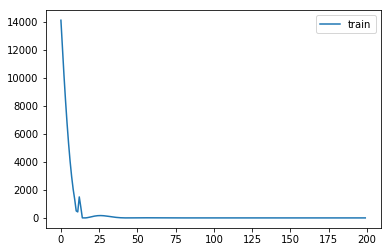

In [130]:
# plot history
history=model.fit(X, y, epochs=200, verbose=0)
plt.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [93]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)